In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Sequential, Linear
from torch.optim import SGD

In [2]:
df = pd.read_csv('datasets/diabetes_balanced.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,105.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0
2,8,183.0,64.0,32.0,105.0,23.3,0.672,32,1
3,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
4,8,125.0,96.0,32.0,105.0,32.0,0.232,54,1


# PyTorch

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# setting device to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X = df.drop('Outcome', axis=1).values
Y = df['Outcome'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Convert NumPy arrays to PyTorch tensors
features_tensor = torch.FloatTensor(X_train)
labels_tensor = torch.FloatTensor(Y_train)

# Create a DataLoader
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 16)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

# Instantiate the model, loss function, and optimizer
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

model.to(device)
features_tensor = features_tensor.to(device)
labels_tensor = labels_tensor.to(device)

# Lists to store parameters and loss history
parameters_history = []
loss_history = []
best_loss = float('inf')
best_parameters = None

for param in model.parameters():
    param.to(device)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        loss.backward()
        optimizer.step()
    # Store parameters and loss at the end of each epoch
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_parameters = [param.data.clone() for param in model.parameters()]
    parameters_history.append([param.data.clone() for param in model.parameters()])
    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

cuda
Epoch [1/100], Loss: 0.6978
Epoch [11/100], Loss: 0.5357
Epoch [21/100], Loss: 0.7072
Epoch [31/100], Loss: 0.7257
Epoch [41/100], Loss: 0.5014
Epoch [51/100], Loss: 0.3935
Epoch [61/100], Loss: 0.4470
Epoch [71/100], Loss: 0.3672
Epoch [81/100], Loss: 0.6053
Epoch [91/100], Loss: 0.4353


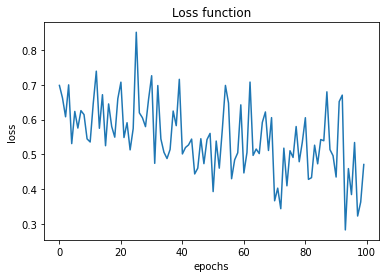

In [92]:

sns.lineplot(x=range(num_epochs), y=loss_history)
plt.title('Loss function')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [93]:

best_loss, best_parameters

(0.2836771607398987,
 [tensor([[ 0.0145, -0.2562,  0.1539,  ...,  0.1492, -0.2758, -0.3464],
          [-0.1880, -0.3102, -0.2878,  ...,  0.2975, -0.1109, -0.0404],
          [ 0.2190, -0.2025,  0.2150,  ..., -0.1705, -0.1146,  0.1039],
          ...,
          [ 0.1486,  0.2612, -0.0389,  ...,  0.2575, -0.2683, -0.3729],
          [-0.2518,  0.1091, -0.2479,  ...,  0.2396,  0.1391, -0.2855],
          [-0.3849, -0.0366,  0.1795,  ..., -0.1141, -0.3299,  0.2764]],
         device='cuda:0'),
  tensor([-0.0864, -0.3238, -0.4843,  0.1379,  0.2192,  0.0758, -0.2026, -0.1644,
          -0.1810, -0.3196, -0.1201,  0.0685, -0.0507, -0.2270,  0.1344, -0.2361,
           0.0838,  0.3310, -0.3272,  0.1329,  0.2699,  0.0317,  0.2198,  0.0996,
           0.1626, -0.1615,  0.0025, -0.3279,  0.0403,  0.3030,  0.1711, -0.1551,
          -0.0088, -0.0189,  0.1917,  0.1914,  0.2084, -0.3427,  0.1336, -0.1937,
          -0.3412,  0.4756,  0.2294, -0.0937,  0.1525, -0.0511,  0.3496,  0.2633,
          -0

In [94]:
model.load_state_dict({param_name: param for param_name, param in zip(model.state_dict().keys(), best_parameters)})

# Set the model to evaluation mode
model.eval()

# new_input = torch.FloatTensor([[3, 132.0, 80.0, 40.0, 102.0, 36.2, 0.442, 42]])  # Replace '...' with your actual input values
new_input = torch.FloatTensor(X_test).to(device)
# y_test_tensor = torch.FloatTensor(Y_test)

# Forward pass to get the prediction
with torch.no_grad():
    prediction = model(new_input)

# obtain the model's output
rounded_prediction = torch.round(prediction)
rounded_prediction = rounded_prediction.cpu()

# Convert the tensor to a scalar
rounded_prediction_value = rounded_prediction.numpy()

# print(f'The model predicts: {rounded_prediction_value}')


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convert the rounded predictions to a NumPy array
rounded_prediction_np = rounded_prediction_value.flatten()

# Compare predictions with actual labels
accuracy = accuracy_score(Y_test, rounded_prediction_np)
conf_matrix = confusion_matrix(Y_test, rounded_prediction_np)
class_report = classification_report(Y_test, rounded_prediction_np)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.71
Confusion Matrix:
[[23 17]
 [ 4 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.57      0.69        40
           1       0.63      0.88      0.73        33

    accuracy                           0.71        73
   macro avg       0.74      0.73      0.71        73
weighted avg       0.75      0.71      0.71        73

